In [23]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
df=pd.read_csv("data.csv")

In [10]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [8]:
df.tail()

,Date,Open,High,Low,Close,Volume
10075,2024-08-30,230.190,230.40,227.48,229.00,52990770.0
10076,2024-09-03,228.550,229.00,221.17,222.77,50190574.0
10077,2024-09-04,221.660,221.78,217.48,220.85,43840196.0
10078,2024-09-05,221.625,225.48,221.52,222.38,36615398.0
10079,2024-09-06,223.950,225.24,219.77,220.86,48370990.0


In [13]:
df.duplicated().sum()

0

In [12]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

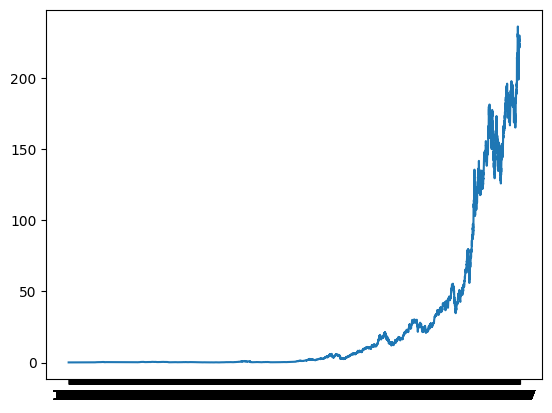

In [29]:
ax=plt.axes()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(df["Date"],df["Open"])

In [ ]:
X=df.drop("",axis=1)
y=df[""]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
model=Sequential()

In [ ]:
model.add(LSTM(50))
model.add(Dense(5))

In [ ]:
model.compile(optimizer='adam')

In [ ]:
model.summary()

In [ ]:
hist=model.fit()